## Spike detection for Amrita's data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)
import pickle as pkl

In [2]:
from keras.layers import RepeatVector, Bidirectional, TimeDistributed
from keras.layers.core import Dropout, Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
def prepare_sequences(x_train, y_train, window_length):
    full_seq = x_train.flatten()
    target_seq = y_train.flatten()
    windows = []
    outliers = []
    for window_start in range(0, len(full_seq) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(full_seq[window_range])
        contain_outlier = target_seq[window_range].sum()>0
        outliers.append(contain_outlier)
        windows.append(window)
    return np.expand_dims(np.array(windows), axis=2), np.array(outliers).astype(np.bool)

In [4]:
def create_lstm_model(hidden_dim, window_length):
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True), input_shape=(window_length, 1)))
    model.add(Dropout(p=0.2))
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=False)))
#     model.add(TimeDistributed(Dense(1, activation='linear')))
#     model.compile(loss='mse', optimizer='adam')
    model.add(Dense(1, activation='sigmoid'))    
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])  
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

In [6]:
folder = '/groups/svoboda/svobodalab/users/Amrita/STVoltron/402361/Annotated/'
cellId = 'Cell_2'

with open(folder + cellId + '_metadata.pkl', 'rb') as f:
    meta = pkl.load(f)

with open(folder + cellId + '_spikes.pkl', 'rb') as f:
    spk = pkl.load(f)

In [8]:
spk

{'F0': array([16707.26150404, 16707.01539234, 16706.76928064, ...,
         9519.73621896,  9519.71162103,  9519.68702311]),
 'anti_pref_ori': 5,
 'baseline': array([[ 0.51063841, -1.76509154, -0.43708166,  0.71785515, -0.700284  ,
         -0.27761316,  0.59578883,  0.56968879,  0.21967955,  0.32500351,
          1.84937412,  0.89075114,  0.6420685 ,  1.21773621, -0.22071186,
          0.19004736,  0.59868917,  0.34145613,  0.22647303, -0.14634985,
          1.68292455],
        [-1.6395951 , -0.40964155, -1.70558284,  0.88539551, -0.09654846,
          1.16474181, -0.03467788, -0.93271097, -0.74820171, -0.69147446,
          0.38609367, -0.97065536,  1.16750948,  1.33019053,  0.36625461,
          1.00536087,  0.76854649, -1.06217837, -0.17508568, -0.64035437,
         -0.72017165],
        [ 3.33724471,  1.23770657,  0.07885997, -1.47245177, -0.6256254 ,
          0.82576932,  0.1360286 ,  0.08811549, -0.79673855,  0.99223897,
         -1.150193  ,  1.55063869,  0.90617055,  1.01530

In [7]:
spkcount, voltr = dat['arr_0'].astype('uint8'), dat['arr_1']

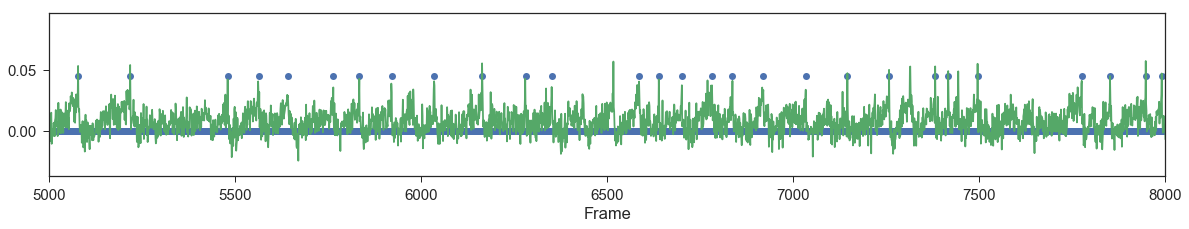

In [8]:
plt.figure(figsize=(20, 3))
plt.plot(spkcount/spkcount.max()*voltr.max(),'o')
plt.plot(voltr)
plt.xlabel('Frame')
plt.xlim([5000, 8000])
plt.show()

In [15]:
window_length = 40
select_only_last_state = False
hidden_dim = 10

x_, contain_outliers_ = prepare_sequences(voltr, spkcount, window_length)
train_test_index = np.random.rand(x_.shape[0])>0.1
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]

x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]

In [16]:
m = create_lstm_model(hidden_dim, window_length)
# check of generated model
plot_model(m, 'model.png')
m.fit(x_train, y_train, batch_size=64, nb_epoch=5, validation_data=(x_test, y_test))
# m.fit(x_train, x_train, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test))


pred_x_test = m.predict(x_test)
# tp, fn, fp, tn = tp_fn_fp_tn(pred_x_test, y_test)
# precision = float(tp) / (tp + fp)
# hit_rate = float(tp) / (tp + fn)
# accuracy = float(tp + tn) / (tp + tn + fp + fn)
# print('A good one should have a higher hit rate and higher accuracy')
# print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
##################################
# For autoencoder
# err = x_test - pred_x_test
# abs_err = (err**2).sum(axis=1)
# sns.boxplot(y_test[:, 0], np.sqrt(abs_err.flatten()))

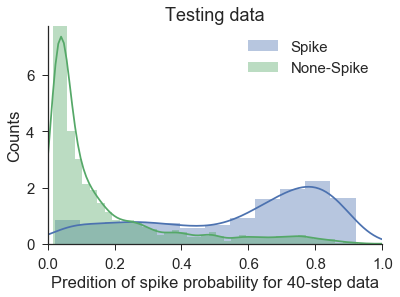

In [19]:
sns.distplot(pred_x_test[y_test[:, 0]], label='Spike')
sns.distplot(pred_x_test[~y_test[:, 0]], label='None-Spike')
sns.despine()
plt.xlim([0,1])
plt.xlabel('Predition of spike probability for 40-step data')
plt.ylabel('Counts')
plt.legend()
plt.title('Testing data')
plt.show()

Train on 32616 samples, validate on 3644 samples
Epoch 1/5
32616/32616 [==============================] - 40s 1ms/step - loss: 0.5641 - val_loss: 0.5223
Epoch 2/5
32616/32616 [==============================] - 36s 1ms/step - loss: 0.3942 - val_loss: 0.2976
Epoch 3/5
32616/32616 [==============================] - 35s 1ms/step - loss: 0.2906 - val_loss: 0.2708
Epoch 4/5
32616/32616 [==============================] - 36s 1ms/step - loss: 0.2694 - val_loss: 0.2449
Epoch 5/5
32616/32616 [==============================] - 35s 1ms/step - loss: 0.2581 - val_loss: 0.2359


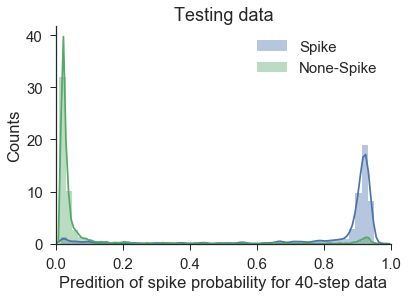

In [20]:
window_length = 40
select_only_last_state = False
hidden_dim = 60

x_, contain_outliers_ = prepare_sequences(voltr, spkcount, window_length)
train_test_index = np.random.rand(x_.shape[0])>0.1
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]

x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]
m = create_lstm_model(hidden_dim, window_length)
m.fit(x_train, y_train, batch_size=64, nb_epoch=5, validation_data=(x_test, y_test))
pred_x_test = m.predict(x_test)
sns.distplot(pred_x_test[y_test[:, 0]], label='Spike')
sns.distplot(pred_x_test[~y_test[:, 0]], label='None-Spike')
sns.despine()
plt.xlim([0,1])
plt.xlabel('Predition of spike probability for 40-step data')
plt.ylabel('Counts')
plt.legend()
plt.title('Testing data')
plt.show()